In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms, models

from PIL import Image

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [4]:
# Root of the repo
PROJECT_ROOT = "."

# Cropped images directory (already generated)
CROP_ROOT = os.path.join(PROJECT_ROOT, "cropped_features")

In [5]:
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = torch.nn.Identity()  # remove classifier head
model.eval()

print("Embedding dimension:", model(torch.zeros(1, 3, 224, 224)).shape)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/chris.shia/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 44.0MB/s]

Embedding dimension: torch.Size([1, 512])


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [7]:
def get_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0)

    with torch.no_grad():
        emb = model(x)

    return emb.squeeze().numpy()  # (512,)

In [8]:
def load_region_embeddings(region_dir):
    X, y = [], []

    for label in os.listdir(region_dir):
        label_dir = os.path.join(region_dir, label)
        if not os.path.isdir(label_dir):
            continue

        for fname in os.listdir(label_dir):
            img_path = os.path.join(label_dir, fname)
            try:
                emb = get_embedding(img_path)
                X.append(emb)
                y.append(label)
            except:
                continue

    return np.array(X), np.array(y)

In [9]:
EYES_DIR = os.path.join(CROP_ROOT, "eyes")

X_eyes, y_eyes = load_region_embeddings(EYES_DIR)

print("Embeddings shape:", X_eyes.shape)
print("Labels:", np.unique(y_eyes, return_counts=True))

Embeddings shape: (6, 512)
Labels: (array(['Arched_Eyebrows'], dtype='<U15'), array([6]))


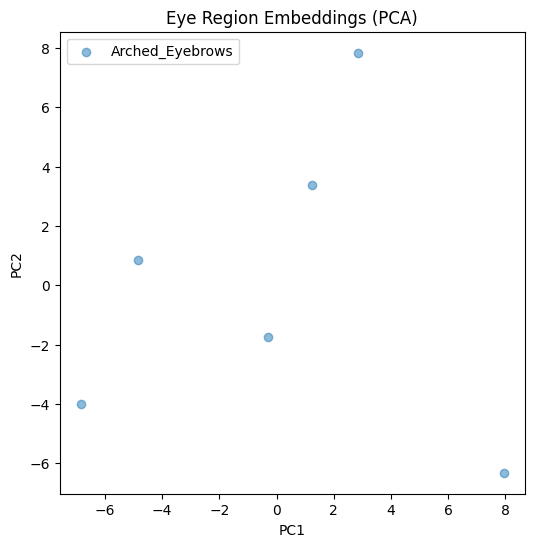

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_eyes)

plt.figure(figsize=(6, 6))
for label in np.unique(y_eyes):
    idx = y_eyes == label
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        label=label,
        alpha=0.5
    )

plt.legend()
plt.title("Eye Region Embeddings (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [ ]:
np.save(os.path.join(PROJECT_ROOT, "eyes_embeddings.npy"), X_eyes)
np.save(os.path.join(PROJECT_ROOT, "eyes_labels.npy"), y_eyes)